## Checando o ambiente carregando bibliotecas e dados

In [1]:
import torch

if torch.cuda.is_available():        
    device = torch.device("cuda")    
    print('There are %d GPU(s) available.' % torch.cuda.device_count())    
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 2060 SUPER


In [2]:
import pandas as pd
import random
import numpy as np
import hdbscan
from umap import UMAP
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
from hyperopt import hp
from hyperopt import fmin, tpe, STATUS_OK, space_eval, Trials
from functools import partial

In [3]:
#train =  pd.read_csv('./datasets/banck/train.csv')
#test =  pd.read_csv('./datasets/banck/test.csv')

antivaxxers = pd.read_csv('./datasets/antivaxxers/antivaxxers_processed.csv')

In [4]:
docs = antivaxxers

## Carregando modelos e gerando embeddings

In [5]:
from sentence_transformers import SentenceTransformer

mpnet_model = SentenceTransformer("all-mpnet-base-v2", device="cuda")
minilm_model = SentenceTransformer("all-MiniLM-L6-v2", device="cuda")
bert_base_model = SentenceTransformer("xlm-r-bert-base-nli-stsb-mean-tokens", device="cuda")

In [6]:
mpnet_embeddings = mpnet_model.encode(docs.text, show_progress_bar=True)
minilm_embeddings = minilm_model.encode(docs.text, show_progress_bar=True)
bert_base_embeddings = bert_base_model.encode(docs.text, show_progress_bar=True)

Batches:   0%|          | 0/680 [00:00<?, ?it/s]

Batches:   0%|          | 0/680 [00:00<?, ?it/s]

Batches:   0%|          | 0/680 [00:00<?, ?it/s]

## Função para gerar os clusters

In [7]:
def generate_clusters(embeddings,
                      n_neighbors,
                      n_components, 
                      min_cluster_size,
                      random_state = None):
    """
    Generate HDBSCAN cluster object after reducing embedding dimensionality with UMAP
    """
    
    umap_embeddings = (UMAP(n_neighbors=n_neighbors, 
                                n_components=n_components, 
                                metric='cosine', 
                                random_state=random_state)
                                .fit_transform(embeddings))

    clusters = hdbscan.HDBSCAN(min_cluster_size = min_cluster_size,
                               metric='euclidean', 
                               cluster_selection_method='eom').fit(umap_embeddings)

    return clusters

## Função para calcular custo

In [8]:
def score_clusters(clusters, prob_threshold = 0.05):
    """
    Returns the label count and cost of a given cluster supplied from running hdbscan
    """
    
    cluster_labels = clusters.labels_
    label_count = len(np.unique(cluster_labels))
    total_num = len(clusters.labels_)
    cost = (np.count_nonzero(clusters.probabilities_ < prob_threshold)/total_num)
    
    return label_count, cost

## Função objetivo para minimizar a perda

In [9]:
def objective(params, embeddings, clusters_lower, clusters_upper):
    """
    Objective function for hyperopt to minimize, which incorporates constraints
    on the number of clusters we want to identify
    """
    
    clusters = generate_clusters(embeddings, 
                                 n_neighbors = params['n_neighbors'], 
                                 n_components = params['n_components'], 
                                 min_cluster_size = params['min_cluster_size'],
                                 random_state = params['random_state'])
    
    label_count, cost = score_clusters(clusters, prob_threshold = 0.05)
    
    #15% penalty on the cost function if outside the desired range of groups
    if (label_count < clusters_lower) | (label_count > clusters_upper):
        penalty = 0.15 
    else:
        penalty = 0
    
    loss = cost + penalty
    
    return {'loss': loss, 'label_count': label_count, 'status': STATUS_OK}

## Otimização baysiana de hiperparametros com Hyperopt

In [10]:
def bayesian_search(embeddings, space, clusters_lower, clusters_upper, max_evals=100):
    """
    Perform bayseian search on hyperopt hyperparameter space to minimize objective function
    """
    
    trials = Trials()
    fmin_objective = partial(objective, embeddings=embeddings, clusters_lower=clusters_lower, clusters_upper=clusters_upper)
    best = fmin(fmin_objective,  
                space = space, 
                algo=tpe.suggest,
                max_evals=max_evals, 
                trials=trials)

    best_params = space_eval(space, best)
    print ('best:')
    print (best_params)
    print (f"label count: {trials.best_trial['result']['label_count']}")
    
    best_clusters = generate_clusters(embeddings, 
                                      n_neighbors = best_params['n_neighbors'], 
                                      n_components = best_params['n_components'], 
                                      min_cluster_size = best_params['min_cluster_size'],
                                      random_state = best_params['random_state'])
    
    return best_params, best_clusters, trials

## Executando função de otimização de hiperparametros para diferentes modelos 

In [11]:
hspace = {
    'n_neighbors': hp.choice('n_neighbors',range(10,20)),
    'n_components': hp.choice('n_components',range(3,10)),
    'min_cluster_size': hp.choice('min_cluster_size',range(10,100)),
    'random_state':42
}

clusters_lower=25
clusters_upper=75
max_evals = 100

In [12]:
mpnet_best_params, mpnet_best_clusters, mpnet_trials = bayesian_search(mpnet_embeddings,
                                                                       space=hspace,
                                                                       clusters_lower=clusters_lower,
                                                                       clusters_upper=clusters_upper,
                                                                       max_evals=max_evals)

100%|██████████| 100/100 [32:36<00:00, 19.57s/trial, best loss: 0.18656349169847766]
best:
{'min_cluster_size': 95, 'n_components': 4, 'n_neighbors': 14, 'random_state': 42}
label count: 10


In [14]:
minilm_best_params, minilm_best_clusters, minilm_trials = bayesian_search(minilm_embeddings,
                                                                          space=hspace,
                                                                          clusters_lower=clusters_lower,
                                                                          clusters_upper=clusters_upper,
                                                                          max_evals=max_evals)

100%|██████████| 100/100 [33:20<00:00, 20.00s/trial, best loss: 0.13705560410246975]
best:
{'min_cluster_size': 72, 'n_components': 3, 'n_neighbors': 16, 'random_state': 42}
label count: 27


In [15]:
bert_base_best_params, bert_base_best_clusters, bert_base_trials = bayesian_search(bert_base_embeddings,
                                                                                   space=hspace,
                                                                                   clusters_lower=clusters_lower,
                                                                                   clusters_upper=clusters_upper,
                                                                                   max_evals=max_evals)

100%|██████████| 100/100 [32:49<00:00, 19.70s/trial, best loss: 0.045255944441889344]
best:
{'min_cluster_size': 24, 'n_components': 6, 'n_neighbors': 14, 'random_state': 42}
label count: 43


## Avaliando e comparando modelos (ARI, MNI e LOSS)

In [21]:
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score

ground_labels = docs['category'].values
model_name =['all-mpnet-base-v2','all-MiniLM-L6-v2','xlm-r-bert-base']

trials_lst = [mpnet_trials,minilm_trials,bert_base_trials]
model_lst = [mpnet_best_clusters, minilm_best_clusters, bert_base_best_clusters]
model_best_params_lst = [mpnet_best_params,minilm_best_params,bert_base_best_params]

loss=[]

ari=[]
mni=[]
loss=[]
n_clusters =[]

min_cluster_size=[]
n_components=[]
n_neighbors=[]
random_state=[]

for trials in trials_lst:
    loss.append(trials.best_trial['result']['loss'])
    best_loss = pd.DataFrame({'LOSS':loss})
    
for model in model_lst:    
    ari.append(np.round(adjusted_rand_score(ground_labels, model.labels_), 3))
    mni.append(np.round(normalized_mutual_info_score(ground_labels, model.labels_), 3))
    n_clusters.append(len(np.unique(model.labels_)))
    best_metrics= pd.DataFrame({'ARI':ari,'MNI':mni, 'n_clusters': n_clusters })

for params in model_best_params_lst:
    min_cluster_size.append(params['min_cluster_size'])
    n_components.append(params['n_components'])
    n_neighbors.append(params['n_neighbors'])
    random_state.append(params['random_state'])
    best_params=pd.DataFrame({'min_cluster_size': min_cluster_size,'n_components':n_components,
                              'n_neighbors':n_neighbors,'random_state':random_state})

model_name = pd.DataFrame(model_name,columns=['Model'])
model_eval = pd.concat([model_name,best_metrics,best_loss, best_params], axis=1, ignore_index=False)
eval = {'Model': model_eval.Model, 'ARI':model_eval.ARI,'MNI':model_eval.MNI,
        'LOSS':model_eval.LOSS, 'n_clusters': model_eval.n_clusters,'min_cluster_size':model_eval.min_cluster_size,
         'n_neighbors':model_eval.n_neighbors,'n_components': model_eval.n_components, 'random_state':model_eval.random_state }
model_eval = pd.DataFrame(eval)

In [22]:
model_eval

,Model,ARI,MNI,LOSS,n_clusters,min_cluster_size,n_neighbors,n_components,random_state
0,all-mpnet-base-v2,0.337,0.763,0.040988,32,57,18,5,42
1,all-MiniLM-L6-v2,0.297,0.731,0.051085,31,77,11,7,42
2,xlm-r-bert-base,0.016,0.354,0.175992,17,54,14,7,42


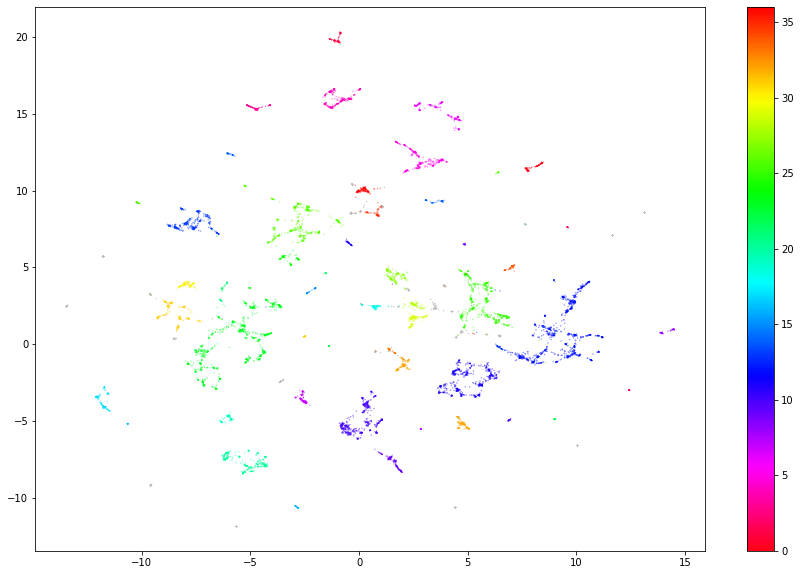

In [378]:
from matplotlib import pyplot as plt
%matplotlib inline

plot_embedding = UMAP(n_neighbors=15, n_components=2,  min_dist=0.1, metric='cosine').fit_transform(mpnet_embeddings)

def ploting_clusters(embeddings,labels):
    result = pd.DataFrame(embeddings, columns=['x', 'y'])
    result['labels'] = labels
    # Visualize clusters
    fig, ax = plt.subplots(figsize=(15, 10))
    outliers = result.loc[result.labels == -1, :]
    clustered = result.loc[result.labels != -1, :]
    plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.15)
    plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
    plt.colorbar()
    #plt.show()
    
ploting_clusters(plot_embedding,mpnet_model_best_clusters.labels_)

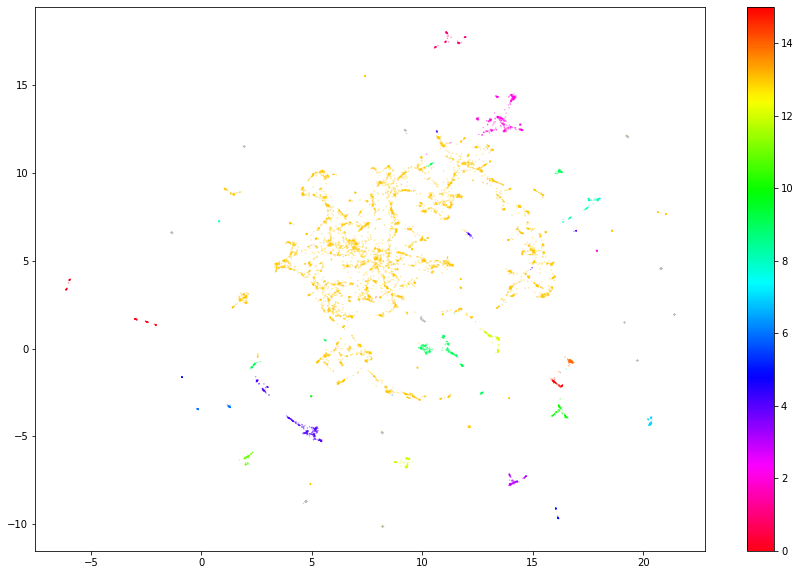

In [379]:
from matplotlib import pyplot as plt
%matplotlib inline

plot_embedding = UMAP(n_neighbors=15, n_components=2,  min_dist=0.1, metric='cosine').fit_transform(bert_base_embeddings)

def ploting_clusters(embeddings,labels):
    result = pd.DataFrame(embeddings, columns=['x', 'y'])
    result['labels'] = labels
    # Visualize clusters
    fig, ax = plt.subplots(figsize=(15, 10))
    outliers = result.loc[result.labels == -1, :]
    clustered = result.loc[result.labels != -1, :]
    plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.15)
    plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
    plt.colorbar()
    #plt.show()
    
ploting_clusters(plot_embedding,bert_base_best_clusters.labels_)

In [24]:
from dbcv import DBCV
from scipy.spatial.distance import euclidean

embeddings = UMAP(n_neighbors=18, n_components=2,  min_dist=0.1, metric='cosine').fit_transform(bert_base_embeddings)
hdbscan_score = DBCV(embeddings, mpnet_best_clusters.labels_, dist_function=euclidean)
hdbscan_score

KeyboardInterrupt: 

## Extraindo tópicos

In [33]:
def clustering_documents(docs,cluster_labels):
    docs_df = pd.DataFrame(docs, columns=["text"])
    docs_df['cluster'] = cluster_labels
    docs_df['doc_id'] = range(len(docs_df))
    docs_per_topic = docs_df.groupby(['cluster'], as_index = False).agg({'text': ' '.join})
    return docs_df, docs_per_topic

In [34]:
docs_df, docs_per_topic = clustering_documents(docs,mpnet_best_clusters.labels_)

In [35]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import nltk

stop_words = nltk.corpus.stopwords.words("portuguese")   

def c_tf_idf(documents, m, ngram_range=(3, 3)):
    count = CountVectorizer(ngram_range=ngram_range,stop_words=stop_words ).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
c_tf_idf, count = c_tf_idf(docs_per_topic.text.values, m=len(docs))

def extract_top_n_words_per_topic(c_tf_idf, count, docs_per_topic, n=10):
    words = count.get_feature_names()
    labels = list(docs_per_topic.cluster)
    tf_idf_transposed = c_tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return words, top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['cluster'])
                     .text
                     .count()
                     .reset_index()
                     .rename({"cluster": "topic", "text": "size"}, axis='columns')
                     .sort_values("size", ascending=False))
    return topic_sizes

words,top_n_words = extract_top_n_words_per_topic(c_tf_idf, count, docs_per_topic, n=5)
topic_sizes = extract_topic_sizes(docs_df); 

## Extraindo intenções

In [36]:
import collections


def  most_common(lst, n_words):
        """
        Return most common n words in list of words
        Arguments:
            lst: list of words
            n_words: int, number of top words by frequency to return
        Returns:
            counter.most_common(n_words): a list of the n most common elements
                                          and their counts from the most
                                          common to the least
        """

        counter = collections.Counter(lst)

        return counter.most_common(n_words)

In [37]:
import spacy


try:
    #nlp = spacy.load("en_core_web_sm")
    nlp = spacy.load("pt_core_news_sm")
except OSError:
    print("Downloading language model for the spaCy dependency parser\n"
                  "(only required the first time this is run)\n")
    from spacy.cli import download
    #download("en_core_web_sm")
    download("pt_core_news_sm")
    #nlp = spacy.load("en_core_web_sm")
    nlp =spacy.load("pt_core_news_sm")

def extract_labels(category_docs):
    """
    Extract labels from documents in the same cluster by concatenating
    most common verbs, ojects, and nouns
    """

    verbs = []
    dobjs = []
    nouns = []
    adjs = []
    
    verb = ''
    dobj = ''
    noun1 = ''
    noun2 = ''

    # for each document, append verbs, dobs, nouns, and adjectives to 
    # running lists for whole cluster
    for i in range(len(category_docs)):
        doc = nlp(category_docs[i])
        for token in doc:
            if token.is_stop==False:
                if token.dep_ == 'ROOT':
                    verbs.append(token.text.lower())

                elif token.dep_=='dobj':
                    dobjs.append(token.lemma_.lower())

                elif token.pos_=='NOUN':
                    nouns.append(token.lemma_.lower())
                    
                elif token.pos_=='ADJ':
                    adjs.append(token.lemma_.lower())
    
    # take most common words of each form
    if len(verbs) > 0:
        verb = most_common(verbs, 1)[0][0]
    
    if len(dobjs) > 0:
        dobj = most_common(dobjs, 1)[0][0]
    
    if len(nouns) > 0:
        noun1 = most_common(nouns, 1)[0][0]
    
    if len(set(nouns)) > 1:
        noun2 = most_common(nouns, 2)[1][0]
    
    # concatenate the most common verb-dobj-noun1-noun2 (if they exist)
    label_words = [verb, dobj]
    
    for word in [noun1, noun2]:
        if word not in label_words:
            label_words.append(word)
    
    if '' in label_words:
        label_words.remove('')
    
    label = '_'.join(label_words)
    
    return label

In [44]:
docs_df[docs_df.cluster==1]

,text,cluster,doc_id
1557,I want to open an account for my children,1,1557
1558,How old do you need to be to use the banks ser...,1,1558
1559,Whats the minimum age to have an account,1,1559
1560,Can my children open an account?,1,1560
1561,How old do I need to be?,1,1561
...,...,...,...
1663,Can I make an account for my daughter?,1,1663
1664,What's the youngest I can be to open an account?,1,1664
1665,Do you have an age requirement when opening an...,1,1665
1666,Is it possible for me to set up separate accou...,1,1666


In [39]:
cluster_labels = np.unique(mpnet_best_clusters.labels_)

label_dict = {}
for label in cluster_labels:
    cluster =  pd.DataFrame(docs_df[docs_df.cluster==label].text)
    cluster = cluster.reset_index().drop(columns=["index"])
    label_dict[label] = extract_labels(cluster.text)

In [40]:
label_dict

{-1: 'charged_money_payment_account',
 0: 'want_account_service',
 1: 'open_account_age_child',
 2: 'change_pin_card',
 3: 'help_passcode_phone_app',
 4: 'need_detail_account',
 5: 'need_identity_verification',
 6: 'charged_fee_transfer',
 7: 'topped_card_money',
 8: 'need_card_verification',
 9: 'transfer_money_beneficiary',
 10: 'tell_card_limit',
 11: 'activate_card_app',
 12: 'charged_fee_withdrawal',
 13: 'tried_cash_withdrawal',
 14: 'use_express_apple_account',
 15: 'charged_currency_exchange',
 16: 'think_rate_exchange',
 17: 'need_refund_account',
 18: 'need_source_fund_money',
 19: 'tried_transfer_account',
 20: 'use_money_currency_account',
 21: 'use_card_limit',
 22: 'need_card_week',
 23: 'declined_card_payment',
 24: 'pending_payment_card',
 25: 'think_card_account',
 26: 'recognize_payment_debit',
 27: 'like_visa_card_mastercard',
 28: 'use_card_country',
 29: 'charged_charge_card',
 30: 'charged_fee_card'}

In [ ]:
import numpy as np
import pandas as pd
from umap import UMAP
from typing import List
from sklearn.preprocessing import MinMaxScaler

import plotly.express as px
import plotly.graph_objects as go


def visualize_topics(topic_model,
                     topics: List[int] = None,
                     top_n_topics: int = None,
                     width: int = 650,
                     height: int = 650) -> go.Figure:
    """ Visualize topics, their sizes, and their corresponding words
    This visualization is highly inspired by LDAvis, a great visualization
    technique typically reserved for LDA.
    Arguments:
        topic_model: A fitted BERTopic instance.
        topics: A selection of topics to visualize
        top_n_topics: Only select the top n most frequent topics
        width: The width of the figure.
        height: The height of the figure.
    Usage:
    To visualize the topics simply run:
    ```python
    topic_model.visualize_topics()
    ```
    Or if you want to save the resulting figure:
    ```python
    fig = topic_model.visualize_topics()
    fig.write_html("path/to/file.html")
    ```
    <iframe src="../../getting_started/visualization/viz.html"
    style="width:1000px; height: 680px; border: 0px;""></iframe>
    """
    # Select topics based on top_n and topics args
    if topics is not None:
        topics = list(topics)
    elif top_n_topics is not None:
        topics = sorted(topic_model.get_topic_freq().Topic.to_list()[1:top_n_topics + 1])
    else:
        topics = sorted(list(topic_model.get_topics().keys()))

    # Extract topic words and their frequencies
    topic_list = sorted(topics)
    frequencies = [topic_model.topic_sizes[topic] for topic in topic_list]
    words = [" | ".join([word[0] for word in topic_model.get_topic(topic)[:5]]) for topic in topic_list]

    # Embed c-TF-IDF into 2D
    all_topics = sorted(list(topic_model.get_topics().keys()))
    indices = np.array([all_topics.index(topic) for topic in topics])
    embeddings = topic_model.c_tf_idf.toarray()[indices]
    embeddings = MinMaxScaler().fit_transform(embeddings)
    embeddings = UMAP(n_neighbors=2, n_components=2, metric='hellinger').fit_transform(embeddings)

    # Visualize with plotly
    df = pd.DataFrame({"x": embeddings[1:, 0], "y": embeddings[1:, 1],
                       "Topic": topic_list[1:], "Words": words[1:], "Size": frequencies[1:]})
    return _plotly_topic_visualization(df, topic_list, width, height)


def _plotly_topic_visualization(df: pd.DataFrame,
                                topic_list: List[str],
                                width: int,
                                height: int):
    """ Create plotly-based visualization of topics with a slider for topic selection """

    def get_color(topic_selected):
        if topic_selected == -1:
            marker_color = ["#B0BEC5" for _ in topic_list[1:]]
        else:
            marker_color = ["red" if topic == topic_selected else "#B0BEC5" for topic in topic_list[1:]]
        return [{'marker.color': [marker_color]}]

    # Prepare figure range
    x_range = (df.x.min() - abs((df.x.min()) * .15), df.x.max() + abs((df.x.max()) * .15))
    y_range = (df.y.min() - abs((df.y.min()) * .15), df.y.max() + abs((df.y.max()) * .15))

    # Plot topics
    fig = px.scatter(df, x="x", y="y", size="Size", size_max=40, template="simple_white", labels={"x": "", "y": ""},
                     hover_data={"Topic": True, "Words": True, "Size": True, "x": False, "y": False})
    fig.update_traces(marker=dict(color="#B0BEC5", line=dict(width=2, color='DarkSlateGrey')))

    # Update hover order
    fig.update_traces(hovertemplate="<br>".join(["<b>Topic %{customdata[0]}</b>",
                                                 "Words: %{customdata[1]}",
                                                 "Size: %{customdata[2]}"]))

    # Create a slider for topic selection
    steps = [dict(label=f"Topic {topic}", method="update", args=get_color(topic)) for topic in topic_list[1:]]
    sliders = [dict(active=0, pad={"t": 50}, steps=steps)]

    # Stylize layout
    fig.update_layout(
        title={
            'text': "<b>Intertopic Distance Map",
            'y': .95,
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': dict(
                size=22,
                color="Black")
        },
        width=width,
        height=height,
        hoverlabel=dict(
            bgcolor="white",
            font_size=16,
            font_family="Rockwell"
        ),
        xaxis={"visible": False},
        yaxis={"visible": False},
        sliders=sliders
    )

    # Update axes ranges
    fig.update_xaxes(range=x_range)
    fig.update_yaxes(range=y_range)

    # Add grid in a 'plus' shape
    fig.add_shape(type="line",
                  x0=sum(x_range) / 2, y0=y_range[0], x1=sum(x_range) / 2, y1=y_range[1],
                  line=dict(color="#CFD8DC", width=2))
    fig.add_shape(type="line",
                  x0=x_range[0], y0=sum(y_range) / 2, x1=x_range[1], y1=sum(y_range) / 2,
                  line=dict(color="#9E9E9E", width=2))
    fig.add_annotation(x=x_range[0], y=sum(y_range) / 2, text="D1", showarrow=False, yshift=10)
    fig.add_annotation(y=y_range[1], x=sum(x_range) / 2, text="D2", showarrow=False, xshift=10)
    fig.data = fig.data[::-1]

    return fig